In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set_style('white')

In [2]:
depths = [15, 30, 50, 70]

# Read insertions.
insertions = pd.concat((pd.read_csv('../data/processed/sanger/star-subsample/'
                                    '{}/insertions.txt'.format(depth), sep='\t')
                          .query('support >= 10')
                          .assign(depth=depth)
                        for depth in depths), axis=0)

# Read CTGs.
ctgs = pd.concat((pd.read_csv('../data/processed/sanger/star-subsample/'
                              '{}/ctgs.txt'.format(depth), sep='\t')
                    .assign(depth=depth)
                  for depth in depths), axis=0)

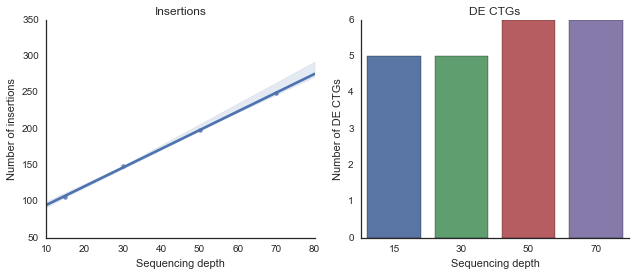

In [3]:
def plot_depth_ctg_count(ctgs, ax=None):
    if ax is None:
        _, ax = plt.subplots()
        
    counts = (ctgs.groupby('depth')['gene_name'].nunique()
                  .reset_index(name='count'))
    sns.barplot(data=counts, x='depth', y='count', ax=ax)
    
    ax.set_xlabel('Sequencing depth')
    ax.set_ylabel('Number of CTGs')

    ax.set_ylim(0, counts['count'].max())
    
    return ax


def plot_depth_insertion_count(insertions, ax=None, kind='bar'):
    if ax is None:
        _, ax = plt.subplots()
        
    counts = (insertions.groupby('depth')['id'].nunique()
                        .reset_index(name='count'))
    
    if kind == 'bar':
        sns.barplot(data=counts, x='depth', y='count', ax=ax)
    elif kind == 'reg':
        sns.regplot(data=counts, x='depth', y='count', ax=ax)
    else:
        raise ValueError('Unknown value for kind')
    
    ax.set_xlabel('Sequencing depth')
    ax.set_ylabel('Number of insertions')
    
    return ax


def plot_depth_overview(insertions, ctgs, axes=None):
    if axes is None:
        _, axes = plt.subplots(figsize=(9, 4), ncols=2, nrows=1)

    #plot_depth_insertion_count(insertions, ax=axes[0])
    #plot_depth_ctg_count(ctgs, ax=axes[1, 0])
    plot_depth_ctg_count(ctgs.query('de_pvalue < 0.05'), ax=axes[1])
    plot_depth_insertion_count(insertions, ax=axes[0], kind='reg')
    
    axes[0].set_title('Insertions')
    #axes[0, 1].set_title('Insertion/depth correlation')
    #axes[1, 0].set_title('CTGs')
    axes[1].set_title('DE CTGs')
    axes[1].set_ylabel('Number of DE CTGs')
    
    sns.despine()
    plt.tight_layout()
    
    return axes
    

fig, axes = plt.subplots(figsize=(9, 4), ncols=2)
plot_depth_overview(insertions, ctgs, axes=axes);


with sns.plotting_context('paper', font_scale=0.7):
    fig, axes = plt.subplots(figsize=(6, 3), ncols=2)
    plot_depth_overview(insertions, ctgs, axes=axes);

    fig.savefig('../reports/supplemental/figures/fig_sx_subsampling.pdf', bbox_inches='tight')
    plt.close(fig)

{15: {'Bmi1', 'Cblb', 'Jak1', 'Stat5b', 'Zfp423'},
 30: {'Bmi1', 'Cblb', 'Jak1', 'Stat5b', 'Zfp423'},
 50: {'Bmi1', 'Cblb', 'Dlx3', 'Jak1', 'Stat5b', 'Zfp423'},
 70: {'Bmi1', 'Cblb', 'Dlx3', 'Jak1', 'Stat5b', 'Zfp423'}}

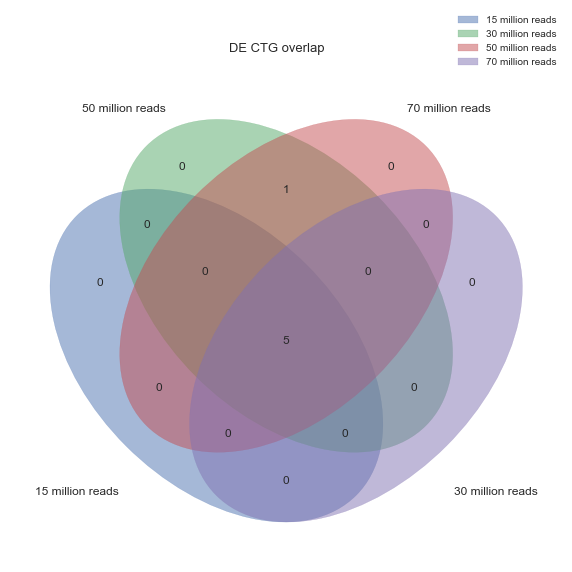

In [4]:
from nbsupport.venn import venn

ctg_genes = {depth: set(grp.query('de_pvalue <= 0.05')['gene_name'])
              for depth, grp in ctgs.groupby('depth')}

fig = venn([ctg_genes[d] for d in depths],
           names=['{} million reads'.format(i) for i in depths],
           colors=sns.color_palette())
fig.suptitle('DE CTG overlap', fontsize=13, y=0.85)

with sns.plotting_context('paper', font_scale=0.7):
    fig = venn([ctg_genes[d] for d in depths],
               names=['{} million reads'.format(i) for i in depths],
               colors=sns.color_palette(), figsize=(6, 5))
    fig.suptitle('DE CTG overlap', fontsize=7, y=0.85)

    fig.savefig('../reports/supplemental/figures/fig_sx_subsampling_venn.pdf', bbox_inches='tight')
    plt.close(fig)
    
    
ctg_genes

In [8]:
depth_overview = pd.pivot_table(ctgs.query('de_pvalue < 0.05'), index='gene_name',
                                columns='depth', values=['n_samples'])

depth_overview

n_samples               
depth            15   30   50   70
gene_name                         
Bmi1            2.0  2.0  2.0  2.0
Cblb            5.0  5.0  5.0  5.0
Dlx3            NaN  NaN  2.0  2.0
Jak1            7.0  7.0  7.0  9.0
Stat5b          5.0  7.0  7.0  7.0
Zfp423          2.0  2.0  2.0  2.0

In [12]:
from io import StringIO

buf = StringIO()
depth_overview['n_samples'].to_latex(buf, index=True)
print(buf.getvalue())

\begin{tabular}{lrrrr}
\toprule
depth &   15 &   30 &   50 &   70 \\
gene\_name &      &      &      &      \\
\midrule
Bmi1      &  2.0 &  2.0 &  2.0 &  2.0 \\
Cblb      &  5.0 &  5.0 &  5.0 &  5.0 \\
Dlx3      &  NaN &  NaN &  2.0 &  2.0 \\
Jak1      &  7.0 &  7.0 &  7.0 &  9.0 \\
Stat5b    &  5.0 &  7.0 &  7.0 &  7.0 \\
Zfp423    &  2.0 &  2.0 &  2.0 &  2.0 \\
\bottomrule
\end{tabular}

